In [1]:
%matplotlib notebook
# %matplotlib nbagg
import numpy as np
from numba import jit
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import timeit

In [2]:
# let's set up our helper functions
def neighCount(board):
    """
    numpy-based neighbor count
    
    Uses numpy's roll (matlab circshift) to "vectorize"
    the calculation of the number of neighbors
    """
    cBoard = np.zeros(board.shape, dtype=np.int64)
    # adjacents
    cBoard += np.roll(board, 1, axis=0)
    cBoard += np.roll(board, -1, axis=0)
    cBoard += np.roll(board, 1, axis=1)
    cBoard += np.roll(board, -1, axis=1)
    # diagonals
    cBoard += np.roll(np.roll(board, 1, axis=0), 1, axis=1)
    cBoard += np.roll(np.roll(board, 1, axis=0), -1, axis=1)
    cBoard += np.roll(np.roll(board, -1, axis=0), 1, axis=1)
    cBoard += np.roll(np.roll(board, -1, axis=0), -1, axis=1)
    return cBoard

@jit
def numbaCount(board):
    """
    numba-based neighbor count
    """
    cBoard = np.zeros(board.shape, dtype=np.int64)
    h, w = board.shape
    for i in range(h):
        for j in range(w):
            cBoard[i,j] += board[i,j-1]
            cBoard[i,j] += board[i,j+1]
            cBoard[i,j] += board[i-1,j]
            cBoard[i,j] += board[i+1,j]
            
            cBoard[i,j] += board[i-1,j-1]
            cBoard[i,j] += board[i+1,j-1]
            cBoard[i,j] += board[i-1,j+1]
            cBoard[i,j] += board[i+1,j+1]
    return cBoard

def updateBoard(board):
    """
    numpy-based board updated
    
    update the board based on the current board state
    and the number of neighbors
    """
    # get the neighbor counts
    nBoard = np.copy(board)
    cBoard = neighCount(board)
    # update the cells as needed
    nBoard[(board == 1) & (cBoard < 2)] = 0
    nBoard[(board == 1) & (cBoard == 2)] = 1
    nBoard[(board == 1) & (cBoard == 3)] = 1
    nBoard[(board == 1) & (cBoard > 3)] = 0
    nBoard[(board == 0) & (cBoard == 3)] = 1
    return nBoard

@jit
def numbaUpdate(board):
    """
    numba-based board update
    """
    h, w = board.shape
    # get the neighbor counts
    nBoard = np.copy(board)
    cBoard = numbaCount(board)
    # update the cells as needed
    for i in range(h):
        for j in range(w):
            n = board[i,j]
            c = cBoard[i,j]
            if (n == 1) and (c < 2):
                    nBoard[i,j] = 0
            elif (n == 1) and (c == 2):
                nBoard[i,j] = 1
            elif (n == 1) and (c == 3):
                nBoard[i,j] = 1
            elif (n == 1) and (c > 2):
                nBoard[i,j] = 0
            elif (n == 0) and (c == 3):
                nBoard[i,j] = 1
    return nBoard

def createRandomBoard(width, height):
    board = np.random.randint(0,2,size=(height, width))
    return board

def createBoard(width, height):
    board = np.zeros(shape=(height, width), dtype=np.int64)
    nIter = 20
    nBlock = 4
    for i in range(nIter):
        x = np.random.randint(width)
        y = np.random.randint(height)
        
        xmin = x - nBlock
        if xmin < 0:
            xmin = 0

        xmax = x + nBlock
        if xmax >= width:
            xmax = width-1

        ymin = y - nBlock
        if ymin < 0:
            ymin = 0

        ymax = y + nBlock
        if ymax >= height:
            ymax = height-1
        
        board[ymin:ymax,xmin:xmax] = 1

    return board

def createBlinker():
    width = 5
    height = 5
    board = np.zeros(shape=(height, width), dtype=np.int64)
    board[2, 1:4] = 1
    return board

def createToad():
    width = 6
    height = 6
    board = np.zeros(shape=(height, width), dtype=np.int64)
    board[2, 1:4] = 1
    board[3, 2:5] = 1
    return board

<IPython.core.display.Javascript object>


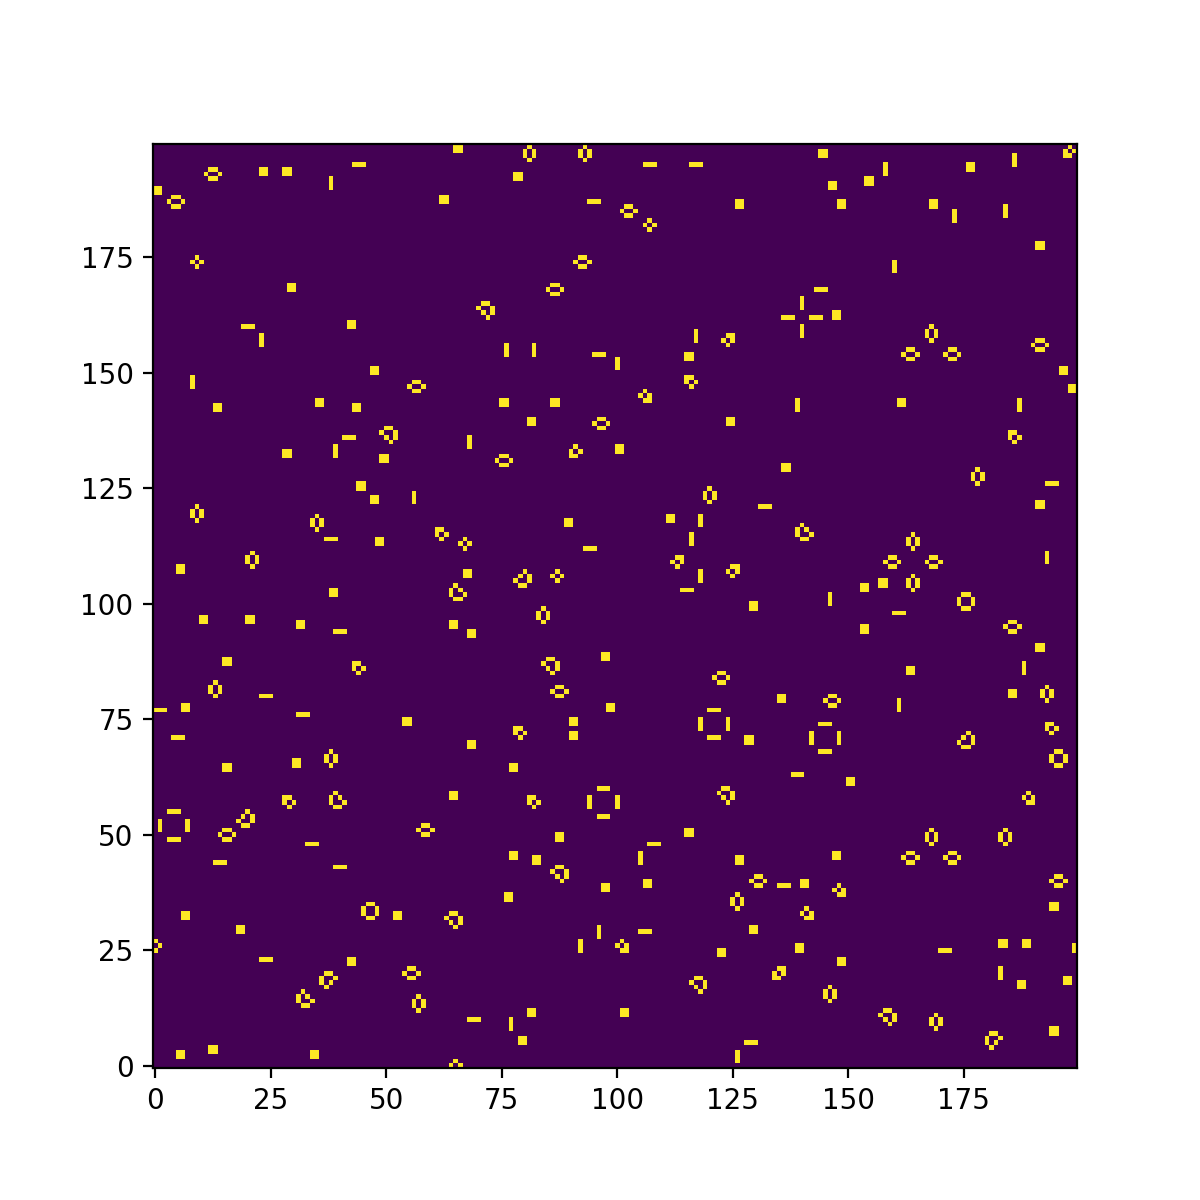

In [3]:
# create the figure object
# anecdotally, (6,6) will not support a board larger than 200x200
# I believe this is a matplotlib issue; something like bokeh may
# be more robust. Moving to something like pyside would obviously
# help immensly as well
fig = plt.figure(figsize=(6,6))
# create the random board
board = createRandomBoard(200,200)

# these are test boards
# board = createBlinker()
# board = createToad()

# start the visualization
im = plt.imshow(board, animated=True, origin="lower")

def updatefig(*args):
    global board
    # numpy update
#     board = updateBoard(board)
    # numba update
    board = numbaUpdate(board)
    # update the image
    im.set_array(board)
    return im,

ani = animation.FuncAnimation(fig, updatefig, interval=5, blit=True)
plt.show()

# Compare NumPy vs. Numba Implementations

In [ ]:
board = createRandomBoard(1000,1000)
print("NumPy Version:")
%timeit -n 100 -r 10 updateBoard(board)
print("Numba Version:")
%timeit -n 100 -r 10 numbaUpdate(board)

I am actually astounded at how much more efficient the numba compiled version is...numba is almost 6x faster